# KADEM Hocine
# BENAHMED Neil

 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("swig")
easyinstall("bbrl>=0.2.2")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")
easyinstall("optuna")
easyinstall("gymnasium")
easyinstall("mazemdp")

import numpy as np
import os
from typing import List

import hydra
import optuna
import yaml
from omegaconf import OmegaConf, DictConfig

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video
import torch.nn as nn
import gymnasium as gym
from bbrl.utils.chrono import Chrono
import matplotlib
import matplotlib.pyplot as plt
from mazemdp.toolbox import sample_categorical
from mazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from functools import partial
import tools 
matplotlib.use("TkAgg")
import gymnasium as gym
import tools
from scipy.stats import ttest_ind

# Environment with 20% of walls and no negative reward when hitting a wall
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0},
    render_mode="human",
)

# Naive actor critic algorithm Function

In [54]:
def naive_actor_critic(
    env: MazeMDPEnv,
    alpha_actor: float,
    alpha_critic: float,
    gamma: float,
    nb_episodes: int = 1000,
    timeout: int = 50,
    render: bool = False,
):
    """
    Naive actor-critic algorithm with entropy and convergence tracking.
    Args:
        env: The environment
        alpha_actor: Learning rate for the actor
        alpha_critic: Learning rate for the critic
        gamma: Discount factor
        nb_episodes: Number of episodes
        timeout: Maximum number of steps per episode
        render: Boolean flag to render the environment
    Returns:
        policy, value_function, trajectories, entropies, convergence_steps
    """
    V = np.zeros(env.nb_states)  # Critic (value function V(s))
    pi = np.ones((env.nb_states, env.action_space.n)) / env.action_space.n  # Actor (policy pi(a|s))

    def renormalize_policy(pi, s):
        pi[s, :] = pi[s, :] / np.sum(pi[s, :])

    trajectories = []
    entropies = []  # List to track entropy
    convergence_steps = 0

    for episode in range(nb_episodes):
        s, _ = env.reset(uniform=True)
        cpt = 0
        terminated = False
        truncated = False
        entropy_episode = 0

        while not (terminated or truncated) and cpt < timeout:
            if render:
                env.draw_v_pi(V, pi.argmax(axis=1))

            a = sample_categorical(pi[s, :])
            s_next, r, terminated, truncated, _ = env.step(a)
            delta = r + gamma * V[s_next] * (1 - terminated) - V[s]
            V[s] = V[s] + alpha_critic * delta

            pi_temp = pi[s, a] + alpha_actor * delta
            pi_temp = max(pi_temp, 1e-8)
            pi[s, a] = pi_temp
            renormalize_policy(pi, s)

            # Calculate entropy for current state
            entropy_episode += -np.sum(pi[s, :] * np.log(pi[s, :] + 1e-8))

            s = s_next
            cpt += 1

        trajectories.append(cpt)
        entropies.append(entropy_episode)  # Store entropy for this episode

        # Check for convergence (e.g., policy does not change significantly)
        if episode > 1 and np.allclose(pi, previous_pi, atol=1e-3):
            convergence_steps = episode
            break

        previous_pi = pi.copy()

    return pi, V, trajectories, entropies, convergence_steps


### Actor-critic hyper-parameters

In [69]:
# Define global constants 
NB_EPISODES = 400

AC_PARAMS = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "human",  # "human" to render the maze OR "rgb_array"
    },
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",
    "nb_episodes": NB_EPISODES,
    "timeout": 200,
    "render": True,
    "nb_repeats": 5,
    "gamma": 0.5,
    
    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

# # Base actor-critic parameters
# AC_PARAMS = {
#     'nb_episodes': NB_EPISODES,
#     'timeout': 50,
#     'gamma': 0.99,
#     'mdp': {
#         'width': 5,
#         'height': 5,
#         'ratio': 0.2,
#         'render_mode': "humain",
#     },
#     "alpha_critic": 0.5,
#     "alpha_actor": 0.5,
# }

### Run multiple experiments

In [66]:
AC_PARAMS['mdp']['render_mode'] = "human"
env = tools.create_maze_from_params(AC_PARAMS)

alpha_actor = AC_PARAMS['alpha_actor']
alpha_critic = AC_PARAMS['alpha_critic']
gamma = AC_PARAMS['alpha_critic'] 
nb_episodes = AC_PARAMS['nb_episodes']
timeout = AC_PARAMS['timeout']
 

pi, V_per_episode, trajectories, entropies, rewards_per_episode = tools.naive_actor_critic(
            env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, render=True
        )

/home/hocine/ENTER/envs/rl/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.draw_v_pi to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.draw_v_pi` for environment variables or `env.get_wrapper_attr('draw_v_pi')` that will search the reminding wrappers.
  logger.warn(


       [ 0,  5, -1, 13, -1],
       [ 1,  6, 10, …

In [67]:
%matplotlib inline
AC_PARAMS['mdp']["render_mode"] = "rgb_array"
n_runs = 5
# Run multiple experiments and gather results
all_values, all_trajectories, all_entropies, all_rewards = tools.run_multiple_experiments(env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, n_runs)

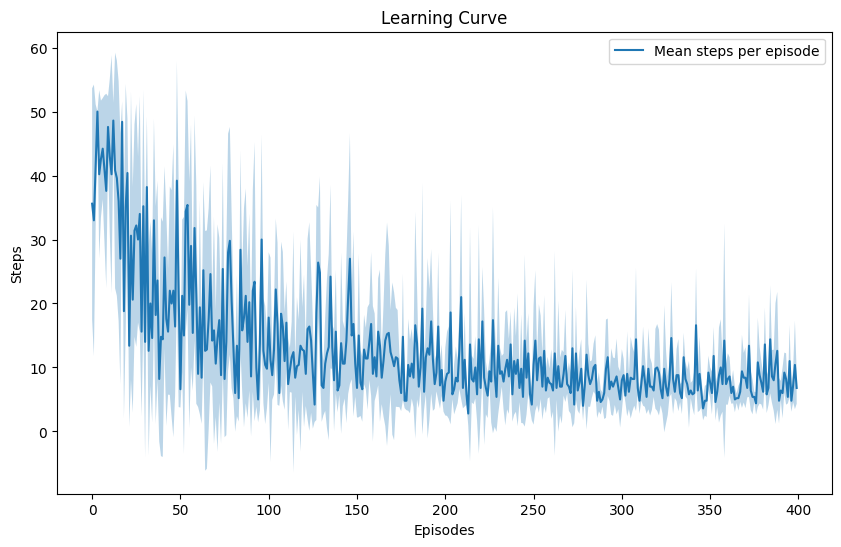

In [70]:
def plot_learning_curve(all_trajectories, plot_name=''):
    # Calculate mean and std for trajectories, assuming they are of different lengths
    max_len = max(map(len, all_trajectories))
    
    # Convert trajectories to arrays of floats and pad with NaN
    padded_trajectories = np.array([np.pad(np.array(t, dtype=float), (0, max_len - len(t)), 'constant', constant_values=np.nan) for t in all_trajectories])
    
    # Calculate mean and std, ignoring NaNs
    mean_trajectories = np.nanmean(padded_trajectories, axis=0)
    std_trajectories = np.nanstd(padded_trajectories, axis=0)
    
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(mean_trajectories, label='Mean steps per episode')
    plt.fill_between(range(len(mean_trajectories)), mean_trajectories - std_trajectories, mean_trajectories + std_trajectories, alpha=0.3)
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title(plot_name)
    plt.legend()
    plt.show()

# Plot the learning curve with the updated function
plot_learning_curve(all_trajectories,'Learning Curve')

# Perform hyper-parameters tuning

## Set up the basic parameters and optimization criteria

In this first step, we define the base parameters for the optimization process, such as the search space for alpha_actor and alpha_critic, the samplers (search strategies), and store the optimization results.

In [84]:
# Total number of trials and the number of values for each hyperparameter
n_trials = 100  # Chosen for sufficient exploration of the search space

# The number of independent runs per trial to average results and reduce variability.
n_runs = 3  # Ensures stability of results across multiple runs

# The number of episodes per trial
nb_episodes = 400  # Chosen for enough training time per trial

In [85]:
from optuna.samplers import TPESampler, RandomSampler, NSGAIISampler, GridSampler

n_values = int(np.sqrt(n_trials))  # Ensure that the number of values matches the total number of trials

# Search space for alpha_actor and alpha_critic (logarithmic scale)
SEARCH_SPACE = {
    "alpha_actor": np.logspace(-3, 0, n_values).tolist(),  # From 1e-3 to 1.0 with n_values points
    "alpha_critic": np.logspace(-3, 0, n_values).tolist()  # Same range for alpha_critic
}

# List of samplers to evaluate
SAMPLERS = {
    "Grid Search": GridSampler(SEARCH_SPACE),
    "Random Search": RandomSampler(),
    "TPE (Bayesian Optimization)": TPESampler(),
    "NSGA-II": NSGAIISampler()
}

# Dictionary to store the results
results = {}

# Base actor-critic parameters
AC_PARAMS = {
    'nb_episodes': nb_episodes,
    'timeout': 50,
    'gamma': 0.8,
    'mdp': {
        'width': 5,
        'height': 5,
        'ratio': 0.2,
        'render_mode': None
    }
}

## Define the optimization loop for each criterion

In [87]:
# Define the optimization criteria
criteria = ['value_norm', 'convergence_time', 'cumulative_reward', 'discounted_cumulative_reward']  

# Loop through each criterion
for criterion in criteria:
    print(f"Optimizing for criterion: {criterion}...")

    # For each criterion, we will loop through the samplers
    for sampler_name, sampler in SAMPLERS.items():
        print(f"Running optimization with {sampler_name}...")

        # Run optimization using the current criterion
        study, best_params, best_performance, all_params, value_norms, trajectories, cumulative_rewards = tools.run_optimization(
            ac_params=AC_PARAMS,
            sampler=sampler,
            n_trials=n_trials,  
            n_runs=n_runs, 
            criterion=criterion  # Optimization based on the selected criterion
        )

        # Store the results for each sampler
        results[f"{criterion}_{sampler_name}"] = {
            "study": study,
            "best_params": best_params,
            "best_performance": best_performance,
            "all_params": all_params,
            "value_norms": value_norms,
            "trajectories": trajectories,
            "cumulative_rewards": cumulative_rewards
        }

        print(f"Best performance for {criterion} using {sampler_name}: {best_performance}")

[I 2024-10-04 15:22:11,944] A new study created in memory with name: no-name-540182ee-51d8-4e4b-8b6f-6595c30c97a7


Optimizing for criterion: value_norm...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 15:22:12,557] Trial 0 finished with value: -4.0209552572931075 and parameters: {'alpha_actor': 0.004641588833612777, 'alpha_critic': 0.1}. Best is trial 0 with value: -4.0209552572931075.
[I 2024-10-04 15:22:12,737] Trial 1 finished with value: -6.586237108788562 and parameters: {'alpha_actor': 0.46415888336127775, 'alpha_critic': 0.1}. Best is trial 1 with value: -6.586237108788562.
[I 2024-10-04 15:22:13,478] Trial 2 finished with value: -1.3460814467251978 and parameters: {'alpha_actor': 0.001, 'alpha_critic': 0.004641588833612777}. Best is trial 1 with value: -6.586237108788562.
[I 2024-10-04 15:22:13,955] Trial 3 finished with value: -5.288830386171573 and parameters: {'alpha_actor': 0.046415888336127774, 'alpha_critic': 0.046415888336127774}. Best is trial 1 with value: -6.586237108788562.
[I 2024-10-04 15:22:14,321] Trial 4 finished with value: -5.34805884886059 and parameters: {'alpha_actor': 0.21544346900318823, 'alpha_critic': 0.046415888336127774}. Best is tria

Best performance for value_norm using Grid Search: -7.173429748573441
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 15:23:02,944] Trial 0 finished with value: -5.700500906326916 and parameters: {'alpha_actor': 0.15324437882904055, 'alpha_critic': 0.07456366279045835}. Best is trial 0 with value: -5.700500906326916.
[I 2024-10-04 15:23:03,609] Trial 1 finished with value: -0.05910462101176795 and parameters: {'alpha_actor': 0.003805501648865331, 'alpha_critic': 0.00011285183132881007}. Best is trial 0 with value: -5.700500906326916.
[I 2024-10-04 15:23:04,073] Trial 2 finished with value: -1.510699348868133 and parameters: {'alpha_actor': 0.44342801008673954, 'alpha_critic': 0.002458062163900342}. Best is trial 0 with value: -5.700500906326916.
[I 2024-10-04 15:23:04,775] Trial 3 finished with value: -2.8471473700961063 and parameters: {'alpha_actor': 0.00538978424462734, 'alpha_critic': 0.014551322747738961}. Best is trial 0 with value: -5.700500906326916.
[I 2024-10-04 15:23:05,330] Trial 4 finished with value: -3.8078229843604148 and parameters: {'alpha_actor': 0.05456148331960251, '

Best performance for value_norm using Random Search: -6.081753017587017
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 15:24:07,436] Trial 0 finished with value: -4.833093690458068 and parameters: {'alpha_actor': 0.062307442382322595, 'alpha_critic': 0.04774963076996059}. Best is trial 0 with value: -4.833093690458068.
[I 2024-10-04 15:24:08,161] Trial 1 finished with value: -0.39353745418546476 and parameters: {'alpha_actor': 0.03979452355703269, 'alpha_critic': 0.0009411284697391718}. Best is trial 0 with value: -4.833093690458068.
[I 2024-10-04 15:24:08,818] Trial 2 finished with value: -3.4503615129392182 and parameters: {'alpha_actor': 3.175536832930623e-05, 'alpha_critic': 0.06303491837202436}. Best is trial 0 with value: -4.833093690458068.
[I 2024-10-04 15:24:09,428] Trial 3 finished with value: -0.028531830957037693 and parameters: {'alpha_actor': 0.08413250133641746, 'alpha_critic': 4.4584956060084405e-05}. Best is trial 0 with value: -4.833093690458068.
[I 2024-10-04 15:24:09,745] Trial 4 finished with value: -5.299695695544695 and parameters: {'alpha_actor': 0.2762342540950163

Best performance for value_norm using TPE (Bayesian Optimization): -7.446685320962286
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 15:24:40,498] Trial 0 finished with value: -0.07835072928123192 and parameters: {'alpha_actor': 0.00013516796577039711, 'alpha_critic': 0.00024730075977790557}. Best is trial 0 with value: -0.07835072928123192.
[I 2024-10-04 15:24:41,096] Trial 1 finished with value: -2.416776875002107 and parameters: {'alpha_actor': 0.0007672010176885548, 'alpha_critic': 0.0069349432619679055}. Best is trial 1 with value: -2.416776875002107.
[I 2024-10-04 15:24:41,773] Trial 2 finished with value: -3.2696761586628718 and parameters: {'alpha_actor': 0.0020692742047757986, 'alpha_critic': 0.03549556419281848}. Best is trial 2 with value: -3.2696761586628718.
[I 2024-10-04 15:24:42,403] Trial 3 finished with value: -0.012577157595075803 and parameters: {'alpha_actor': 0.04472344699400176, 'alpha_critic': 2.0295459695630365e-05}. Best is trial 2 with value: -3.2696761586628718.
[I 2024-10-04 15:24:43,037] Trial 4 finished with value: -1.3225531932824628 and parameters: {'alpha_actor': 4.6124

Best performance for value_norm using NSGA-II: -6.978424436138171
Optimizing for criterion: convergence_time...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 15:25:39,601] Trial 0 finished with value: 31.210833333333333 and parameters: {'alpha_actor': 0.004641588833612777, 'alpha_critic': 0.1}. Best is trial 0 with value: 31.210833333333333.
[I 2024-10-04 15:25:39,829] Trial 1 finished with value: 11.330833333333334 and parameters: {'alpha_actor': 0.46415888336127775, 'alpha_critic': 0.1}. Best is trial 1 with value: 11.330833333333334.
[I 2024-10-04 15:25:40,512] Trial 2 finished with value: 37.03 and parameters: {'alpha_actor': 0.001, 'alpha_critic': 0.004641588833612777}. Best is trial 1 with value: 11.330833333333334.
[I 2024-10-04 15:25:40,964] Trial 3 finished with value: 24.108333333333334 and parameters: {'alpha_actor': 0.046415888336127774, 'alpha_critic': 0.046415888336127774}. Best is trial 1 with value: 11.330833333333334.
[I 2024-10-04 15:25:41,265] Trial 4 finished with value: 15.165 and parameters: {'alpha_actor': 0.21544346900318823, 'alpha_critic': 0.046415888336127774}. Best is trial 1 with value: 11.33083333

Best performance for convergence_time using Grid Search: 6.783333333333334
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 15:26:30,878] Trial 0 finished with value: 33.77 and parameters: {'alpha_actor': 0.0025297999453285304, 'alpha_critic': 0.00010036416351660637}. Best is trial 0 with value: 33.77.
[I 2024-10-04 15:26:31,572] Trial 1 finished with value: 37.86333333333333 and parameters: {'alpha_actor': 0.3129522478720376, 'alpha_critic': 7.945265627506855e-05}. Best is trial 0 with value: 33.77.
[I 2024-10-04 15:26:32,124] Trial 2 finished with value: 29.965833333333336 and parameters: {'alpha_actor': 0.17398368522735508, 'alpha_critic': 0.005019816787965228}. Best is trial 2 with value: 29.965833333333336.
[I 2024-10-04 15:26:32,821] Trial 3 finished with value: 38.12916666666667 and parameters: {'alpha_actor': 0.03877783576152993, 'alpha_critic': 0.0006144341993366999}. Best is trial 2 with value: 29.965833333333336.
[I 2024-10-04 15:26:33,465] Trial 4 finished with value: 35.2475 and parameters: {'alpha_actor': 0.0089374179377743, 'alpha_critic': 0.06320329917480667}. Best is trial 2 w

Best performance for convergence_time using Random Search: 6.868333333333334
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 15:27:33,480] Trial 0 finished with value: 35.5475 and parameters: {'alpha_actor': 0.0017130092809369297, 'alpha_critic': 3.45217813505566e-05}. Best is trial 0 with value: 35.5475.
[I 2024-10-04 15:27:34,192] Trial 1 finished with value: 38.885 and parameters: {'alpha_actor': 2.5164277660436528e-05, 'alpha_critic': 0.0004709743611906466}. Best is trial 0 with value: 35.5475.
[I 2024-10-04 15:27:34,843] Trial 2 finished with value: 34.7675 and parameters: {'alpha_actor': 1.3233453758920075e-05, 'alpha_critic': 4.662611336576175e-05}. Best is trial 2 with value: 34.7675.
[I 2024-10-04 15:27:35,511] Trial 3 finished with value: 35.88916666666667 and parameters: {'alpha_actor': 0.0008959772321903396, 'alpha_critic': 0.0002833437176043969}. Best is trial 2 with value: 34.7675.
[I 2024-10-04 15:27:35,925] Trial 4 finished with value: 21.043333333333337 and parameters: {'alpha_actor': 0.14044709375799638, 'alpha_critic': 0.020946164341371205}. Best is trial 4 with value: 21.043

Best performance for convergence_time using TPE (Bayesian Optimization): 6.4991666666666665
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 15:28:07,250] Trial 0 finished with value: 32.62083333333333 and parameters: {'alpha_actor': 0.0015152822701396365, 'alpha_critic': 0.0061504323819391886}. Best is trial 0 with value: 32.62083333333333.
[I 2024-10-04 15:28:07,944] Trial 1 finished with value: 37.64916666666667 and parameters: {'alpha_actor': 0.00235407143524838, 'alpha_critic': 0.011216226227786025}. Best is trial 0 with value: 32.62083333333333.
[I 2024-10-04 15:28:08,582] Trial 2 finished with value: 34.35666666666666 and parameters: {'alpha_actor': 0.07542496825162748, 'alpha_critic': 0.00784858997686963}. Best is trial 0 with value: 32.62083333333333.
[I 2024-10-04 15:28:08,989] Trial 3 finished with value: 21.424166666666668 and parameters: {'alpha_actor': 0.11546212049355514, 'alpha_critic': 0.05625888583899371}. Best is trial 3 with value: 21.424166666666668.
[I 2024-10-04 15:28:09,627] Trial 4 finished with value: 34.44333333333333 and parameters: {'alpha_actor': 0.0020184040883810205, 'alpha_crit

Best performance for convergence_time using NSGA-II: 6.213333333333333
Optimizing for criterion: cumulative_reward...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 15:29:07,788] Trial 0 finished with value: -240.0 and parameters: {'alpha_actor': 0.004641588833612777, 'alpha_critic': 0.1}. Best is trial 0 with value: -240.0.
[I 2024-10-04 15:29:08,045] Trial 1 finished with value: -367.0 and parameters: {'alpha_actor': 0.46415888336127775, 'alpha_critic': 0.1}. Best is trial 1 with value: -367.0.
[I 2024-10-04 15:29:08,773] Trial 2 finished with value: -138.33333333333334 and parameters: {'alpha_actor': 0.001, 'alpha_critic': 0.004641588833612777}. Best is trial 1 with value: -367.0.
[I 2024-10-04 15:29:09,164] Trial 3 finished with value: -330.6666666666667 and parameters: {'alpha_actor': 0.046415888336127774, 'alpha_critic': 0.046415888336127774}. Best is trial 1 with value: -367.0.
[I 2024-10-04 15:29:09,418] Trial 4 finished with value: -366.6666666666667 and parameters: {'alpha_actor': 0.21544346900318823, 'alpha_critic': 0.046415888336127774}. Best is trial 1 with value: -367.0.
[I 2024-10-04 15:29:09,933] Trial 5 finished with

Best performance for cumulative_reward using Grid Search: -393.6666666666667
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 15:29:58,442] Trial 0 finished with value: -209.66666666666666 and parameters: {'alpha_actor': 0.5972230232318171, 'alpha_critic': 0.00215911681164122}. Best is trial 0 with value: -209.66666666666666.
[I 2024-10-04 15:29:59,168] Trial 1 finished with value: -141.0 and parameters: {'alpha_actor': 8.400129782348125e-05, 'alpha_critic': 4.988064327416225e-05}. Best is trial 0 with value: -209.66666666666666.
[I 2024-10-04 15:29:59,926] Trial 2 finished with value: -137.0 and parameters: {'alpha_actor': 6.109932002377001e-05, 'alpha_critic': 0.44709371374786794}. Best is trial 0 with value: -209.66666666666666.
[I 2024-10-04 15:30:00,268] Trial 3 finished with value: -335.6666666666667 and parameters: {'alpha_actor': 0.19838579300229608, 'alpha_critic': 0.039853674309018775}. Best is trial 3 with value: -335.6666666666667.
[I 2024-10-04 15:30:00,927] Trial 4 finished with value: -179.66666666666666 and parameters: {'alpha_actor': 0.0004189064550812906, 'alpha_critic': 0.0006

Best performance for cumulative_reward using Random Search: -394.0
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 15:30:57,941] Trial 0 finished with value: -113.33333333333333 and parameters: {'alpha_actor': 0.05347094719540185, 'alpha_critic': 6.448185818329902e-05}. Best is trial 0 with value: -113.33333333333333.
[I 2024-10-04 15:30:58,576] Trial 1 finished with value: -189.0 and parameters: {'alpha_actor': 0.0031111292404747467, 'alpha_critic': 0.0002803891901360943}. Best is trial 1 with value: -189.0.
[I 2024-10-04 15:30:59,378] Trial 2 finished with value: -106.0 and parameters: {'alpha_actor': 4.5877419325526736e-05, 'alpha_critic': 3.090674633384676e-05}. Best is trial 1 with value: -189.0.
[I 2024-10-04 15:31:00,023] Trial 3 finished with value: -201.33333333333334 and parameters: {'alpha_actor': 0.0005173049667190352, 'alpha_critic': 0.00022825342656099715}. Best is trial 3 with value: -201.33333333333334.
[I 2024-10-04 15:31:00,752] Trial 4 finished with value: -140.0 and parameters: {'alpha_actor': 0.009116223934177617, 'alpha_critic': 0.0008483034402776658}. Best is tr

Best performance for cumulative_reward using TPE (Bayesian Optimization): -397.3333333333333
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 15:31:32,849] Trial 0 finished with value: -133.33333333333334 and parameters: {'alpha_actor': 2.1770314179350755e-05, 'alpha_critic': 0.00011645729265702984}. Best is trial 0 with value: -133.33333333333334.
[I 2024-10-04 15:31:33,514] Trial 1 finished with value: -178.0 and parameters: {'alpha_actor': 0.0073028535757116405, 'alpha_critic': 0.2717496476595274}. Best is trial 1 with value: -178.0.
[I 2024-10-04 15:31:33,811] Trial 2 finished with value: -365.0 and parameters: {'alpha_actor': 0.04486788234894666, 'alpha_critic': 0.9347225547572892}. Best is trial 2 with value: -365.0.
[I 2024-10-04 15:31:34,522] Trial 3 finished with value: -151.0 and parameters: {'alpha_actor': 1.3510228006072142e-05, 'alpha_critic': 0.00010718640468008736}. Best is trial 2 with value: -365.0.
[I 2024-10-04 15:31:35,190] Trial 4 finished with value: -172.33333333333334 and parameters: {'alpha_actor': 0.5652115156439041, 'alpha_critic': 3.819611949073604e-05}. Best is trial 2 with value: -

Best performance for cumulative_reward using NSGA-II: -394.3333333333333
Optimizing for criterion: discounted_cumulative_reward...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 15:32:29,709] Trial 0 finished with value: -1.015876496062982 and parameters: {'alpha_actor': 0.004641588833612777, 'alpha_critic': 0.1}. Best is trial 0 with value: -1.015876496062982.
[I 2024-10-04 15:32:29,966] Trial 1 finished with value: -1.3628497836161462 and parameters: {'alpha_actor': 0.46415888336127775, 'alpha_critic': 0.1}. Best is trial 1 with value: -1.3628497836161462.
[I 2024-10-04 15:32:30,612] Trial 2 finished with value: -3.1431117346906894 and parameters: {'alpha_actor': 0.001, 'alpha_critic': 0.004641588833612777}. Best is trial 2 with value: -3.1431117346906894.
[I 2024-10-04 15:32:31,076] Trial 3 finished with value: -1.6895182027260367 and parameters: {'alpha_actor': 0.046415888336127774, 'alpha_critic': 0.046415888336127774}. Best is trial 2 with value: -3.1431117346906894.
[I 2024-10-04 15:32:31,405] Trial 4 finished with value: -2.8829529188844063 and parameters: {'alpha_actor': 0.21544346900318823, 'alpha_critic': 0.046415888336127774}. Best is

Best performance for discounted_cumulative_reward using Grid Search: -3.620138778296321
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 15:33:19,624] Trial 0 finished with value: -1.3716503616108973 and parameters: {'alpha_actor': 0.1561743345120344, 'alpha_critic': 0.017129869147457826}. Best is trial 0 with value: -1.3716503616108973.
[I 2024-10-04 15:33:20,175] Trial 1 finished with value: -1.9999000724454365 and parameters: {'alpha_actor': 0.04859644748504747, 'alpha_critic': 0.00243415842900076}. Best is trial 1 with value: -1.9999000724454365.
[I 2024-10-04 15:33:20,819] Trial 2 finished with value: -2.34041344917183 and parameters: {'alpha_actor': 0.0002810794764036053, 'alpha_critic': 1.4031462160015016e-05}. Best is trial 2 with value: -2.34041344917183.
[I 2024-10-04 15:33:21,525] Trial 3 finished with value: -2.1316172816519185 and parameters: {'alpha_actor': 0.12336434425205202, 'alpha_critic': 0.00042481010787754513}. Best is trial 2 with value: -2.34041344917183.
[I 2024-10-04 15:33:22,112] Trial 4 finished with value: -3.407697693900935 and parameters: {'alpha_actor': 0.003651282834530982, 

Best performance for discounted_cumulative_reward using Random Search: -3.641377744663634
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 15:34:21,319] Trial 1 finished with value: -1.978253856842155 and parameters: {'alpha_actor': 0.12442169097220997, 'alpha_critic': 0.042718651444061735}. Best is trial 0 with value: -3.3285669482321794.
[I 2024-10-04 15:34:22,028] Trial 2 finished with value: -2.4866477917757313 and parameters: {'alpha_actor': 0.0023409333207587103, 'alpha_critic': 0.0009998907531649042}. Best is trial 0 with value: -3.3285669482321794.
[I 2024-10-04 15:34:22,757] Trial 3 finished with value: -1.473237754986603 and parameters: {'alpha_actor': 3.901096106795909e-05, 'alpha_critic': 6.823931337867507e-05}. Best is trial 0 with value: -3.3285669482321794.
[I 2024-10-04 15:34:23,482] Trial 4 finished with value: -2.011219430217627 and parameters: {'alpha_actor': 0.0075789777450069, 'alpha_critic': 0.004722455779380981}. Best is trial 0 with value: -3.3285669482321794.
[I 2024-10-04 15:34:24,245] Trial 5 finished with value: -1.0726046777534608 and parameters: {'alpha_actor': 3.067498230199403

Best performance for discounted_cumulative_reward using TPE (Bayesian Optimization): -3.5940938865099206
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 15:35:21,372] Trial 0 finished with value: -3.5183432285225753 and parameters: {'alpha_actor': 0.009337004153886521, 'alpha_critic': 1.5936074807018688e-05}. Best is trial 0 with value: -3.5183432285225753.
[I 2024-10-04 15:35:22,061] Trial 1 finished with value: -2.317227784058235 and parameters: {'alpha_actor': 0.0006964285752404253, 'alpha_critic': 7.296813762659402e-05}. Best is trial 0 with value: -3.5183432285225753.
[I 2024-10-04 15:35:22,259] Trial 2 finished with value: -1.9652214467453302 and parameters: {'alpha_actor': 0.5219144840564237, 'alpha_critic': 0.08856310752179158}. Best is trial 0 with value: -3.5183432285225753.
[I 2024-10-04 15:35:22,888] Trial 3 finished with value: -1.9265737917314667 and parameters: {'alpha_actor': 0.00034864359375198675, 'alpha_critic': 0.04402686424959929}. Best is trial 0 with value: -3.5183432285225753.
[I 2024-10-04 15:35:23,524] Trial 4 finished with value: -3.5011262377476626 and parameters: {'alpha_actor': 4.234237042892

Best performance for discounted_cumulative_reward using NSGA-II: -3.626159559936223


In [99]:
import pickle

# # Save the `results` dictionary to a file
# with open('optimization_results_2.pkl', 'wb') as f:
#     pickle.dump(results, f)

# print("Results saved to optimization_results.pkl")

# Load the `results` dictionary from the file
with open('optimization_results_2.pkl', 'rb') as f:
    results = pickle.load(f)

print("Results loaded from optimization_results.pkl")


Results saved to optimization_results.pkl
Results loaded from optimization_results.pkl


# The best hyper-parameters 

In [91]:
from tabulate import tabulate

# Summarize the best hyperparameters and performance for each criterion
for criterion in criteria:
    print(f"\n### Summary of results for {criterion.capitalize()} optimization ###\n")

    # Prepare a table for displaying results
    table_data = []
    headers = ["Sampler", "Best alpha_actor", "Best alpha_critic", f"Best {criterion.capitalize()}"]

    for sampler_name in SAMPLERS.keys():
        result_key = f"{criterion}_{sampler_name}"
        best_params = results[result_key]["best_params"]
        best_performance = results[result_key]["best_performance"]

        # Extract the best params and performance for the table
        row = [
            sampler_name,  # Sampler name
            best_params.get("alpha_actor", "N/A"),  # Best alpha_actor
            best_params.get("alpha_critic", "N/A"),  # Best alpha_critic
            abs(best_performance)  # Best performance (absolute value for readability)
        ]
        table_data.append(row)

    # Display the results in a nice table format
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))
    print("\n" + "=" * 60 + "\n")


### Summary of results for Value_norm optimization ###

╒═════════════════════════════╤════════════════════╤═════════════════════╤═══════════════════╕
│ Sampler                     │   Best alpha_actor │   Best alpha_critic │   Best Value_norm │
╞═════════════════════════════╪════════════════════╪═════════════════════╪═══════════════════╡
│ Grid Search                 │           0.464159 │            0.215443 │           21.5395 │
├─────────────────────────────┼────────────────────┼─────────────────────┼───────────────────┤
│ Random Search               │           0.202449 │            0.329326 │           21.5866 │
├─────────────────────────────┼────────────────────┼─────────────────────┼───────────────────┤
│ TPE (Bayesian Optimization) │           0.603839 │            0.393222 │           21.5778 │
├─────────────────────────────┼────────────────────┼─────────────────────┼───────────────────┤
│ NSGA-II                     │           0.143086 │            0.205288 │           21.

## The Learning Curves for the best hyperparameters

In [131]:
def plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, metric_name, metric_function):
    """
    Fonction générique pour tracer une métrique donnée (récompenses cumulées, étapes de convergence, valeurs moyennes, etc.)
    pour chaque critère et chaque méthode d'optimisation.
    
    Args:
        - criteria: Liste des critères d'optimisation.
        - results: Dictionnaire contenant les résultats de chaque critère et méthode.
        - n_runs: Nombre de runs à exécuter.
        - env: Environnement utilisé pour les expériences.
        - AC_PARAMS: Paramètres pour l'algorithme acteur-critique.
        - metric_name: Nom de la métrique à afficher dans le titre (par exemple "Rewards", "Convergence Steps").
        - metric_function: Fonction qui calcule la métrique à tracer.
    """
    # Définir les couleurs pour chaque méthode d'optimisation
    colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs

    # Créer une figure pour chaque critère (un seul graphique par critère)
    fig, axes = plt.subplots(1, len(criteria), figsize=(40, 10), sharey=True)
    fig.suptitle(f"{metric_name} Learning Curves for Each Criterion", fontsize=16)

    # Itérer à travers chaque critère
    for i, criterion in enumerate(criteria):
        ax = axes[i]  # Accéder à l'axe correspondant au critère
        
        # Itérer à travers chaque méthode d'optimisation
        for j, (sampler_name, color) in enumerate(zip(SAMPLERS.keys(), colors.colors)):
            # Récupérer la clé des résultats pour le critère et le sampler
            result_key = f"{criterion}_{sampler_name}"
            result = results[result_key]
            
            # Trouver les meilleurs hyperparamètres à partir des résultats de l'étude
            best_params = result['best_params']
            best_alpha_actor = best_params['alpha_actor']
            best_alpha_critic = best_params['alpha_critic']
            
            # Ré-exécuter l'expérience avec les meilleurs hyperparamètres
            experiment_output = tools.run_multiple_experiments(
                env, best_alpha_actor, best_alpha_critic, AC_PARAMS['gamma'], AC_PARAMS['nb_episodes'], AC_PARAMS['timeout'], n_runs
            )
            
            # Appeler la fonction pour calculer la métrique spécifique et obtenir les données à tracer
            metric_values = metric_function(experiment_output)
            
            # Tracer la courbe de la métrique pour cette méthode
            ax.plot(metric_values, label=sampler_name, color=color)
            
            # Ajouter un titre, des étiquettes et un quadrillage
            ax.set_title(f"{criterion.capitalize()}", fontsize=12)
            ax.set_xlabel("Episodes")
            ax.set_ylabel(f"Average {metric_name}")
            ax.grid(True)

    # Ajouter une légende en dehors du graphique pour chaque méthode d'optimisation
    plt.legend(title="Optimization Techniques", loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(SAMPLERS))

    # Ajuster la mise en page
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Afficher le graphique
    plt.show()

def compute_avg_values(experiment_output):
    all_values, _, _, _ = experiment_output
    # Calculer la moyenne des valeurs sur tous les runs (axis=0)
    avg_values_per_episode = np.mean(all_values, axis=0)
    # Calculer la moyenne des moyennes sur l'axe des états
    return np.mean(avg_values_per_episode, axis=1)

def compute_cumulative_rewards(experiment_output):
    _, _, _, rewards_per_episode = experiment_output
    # Calculer la somme des récompenses cumulées pour chaque épisode
    return np.mean(rewards_per_episode, axis=0)

def compute_convergence_steps(experiment_output):
    _, trajectories, _, _ = experiment_output
    # Calculer la moyenne des étapes de convergence par épisode
    return np.mean(trajectories, axis=0)


### Steps per episode Learning Curves

/tmp/ipykernel_69549/723068784.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


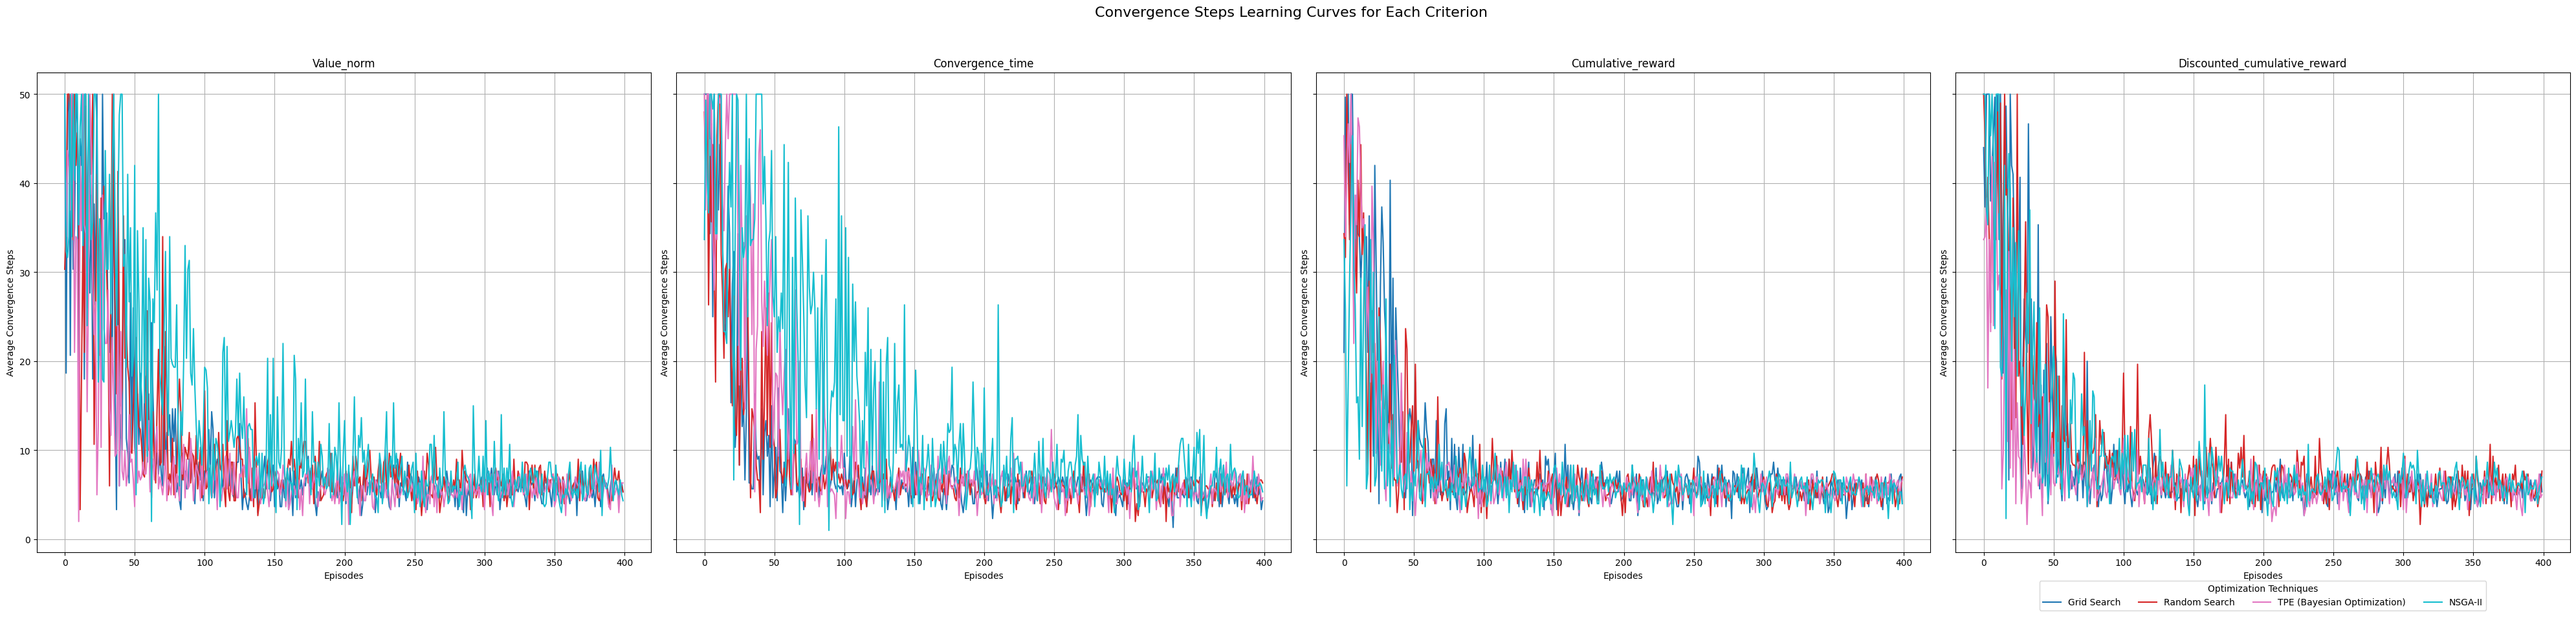

In [132]:
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Convergence Steps", compute_convergence_steps)


### Mean Values Learing Curves

/tmp/ipykernel_69549/723068784.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


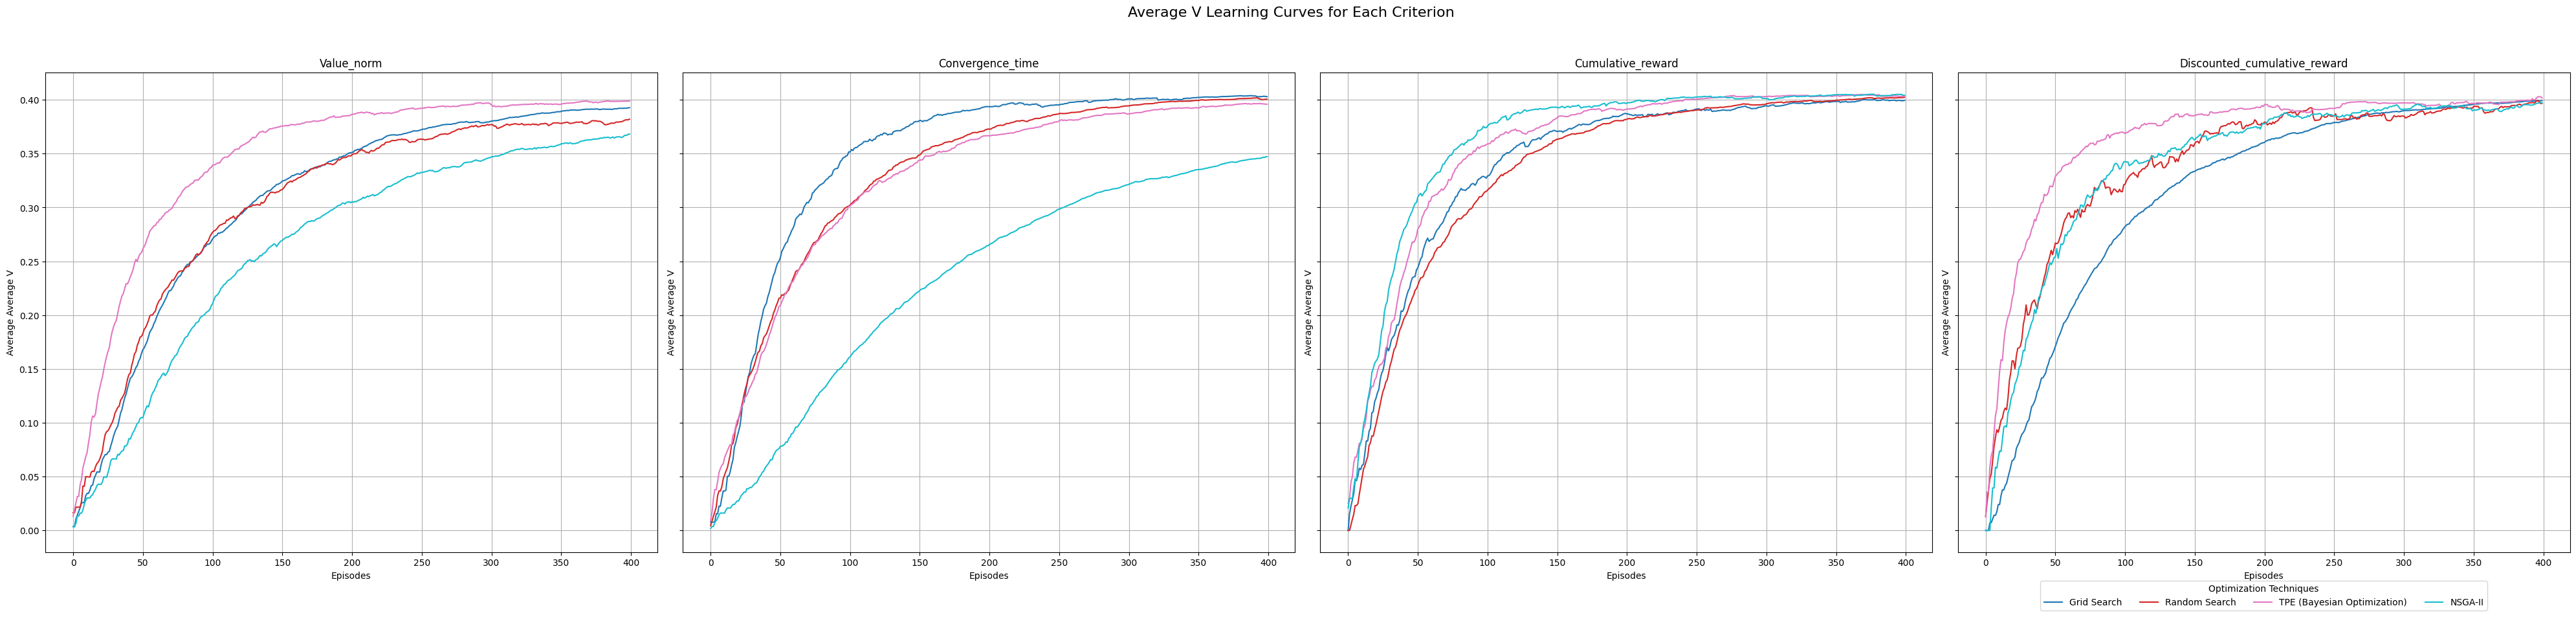

In [133]:
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Average V", compute_avg_values)


### Rewards Learning Curves

/tmp/ipykernel_69549/723068784.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


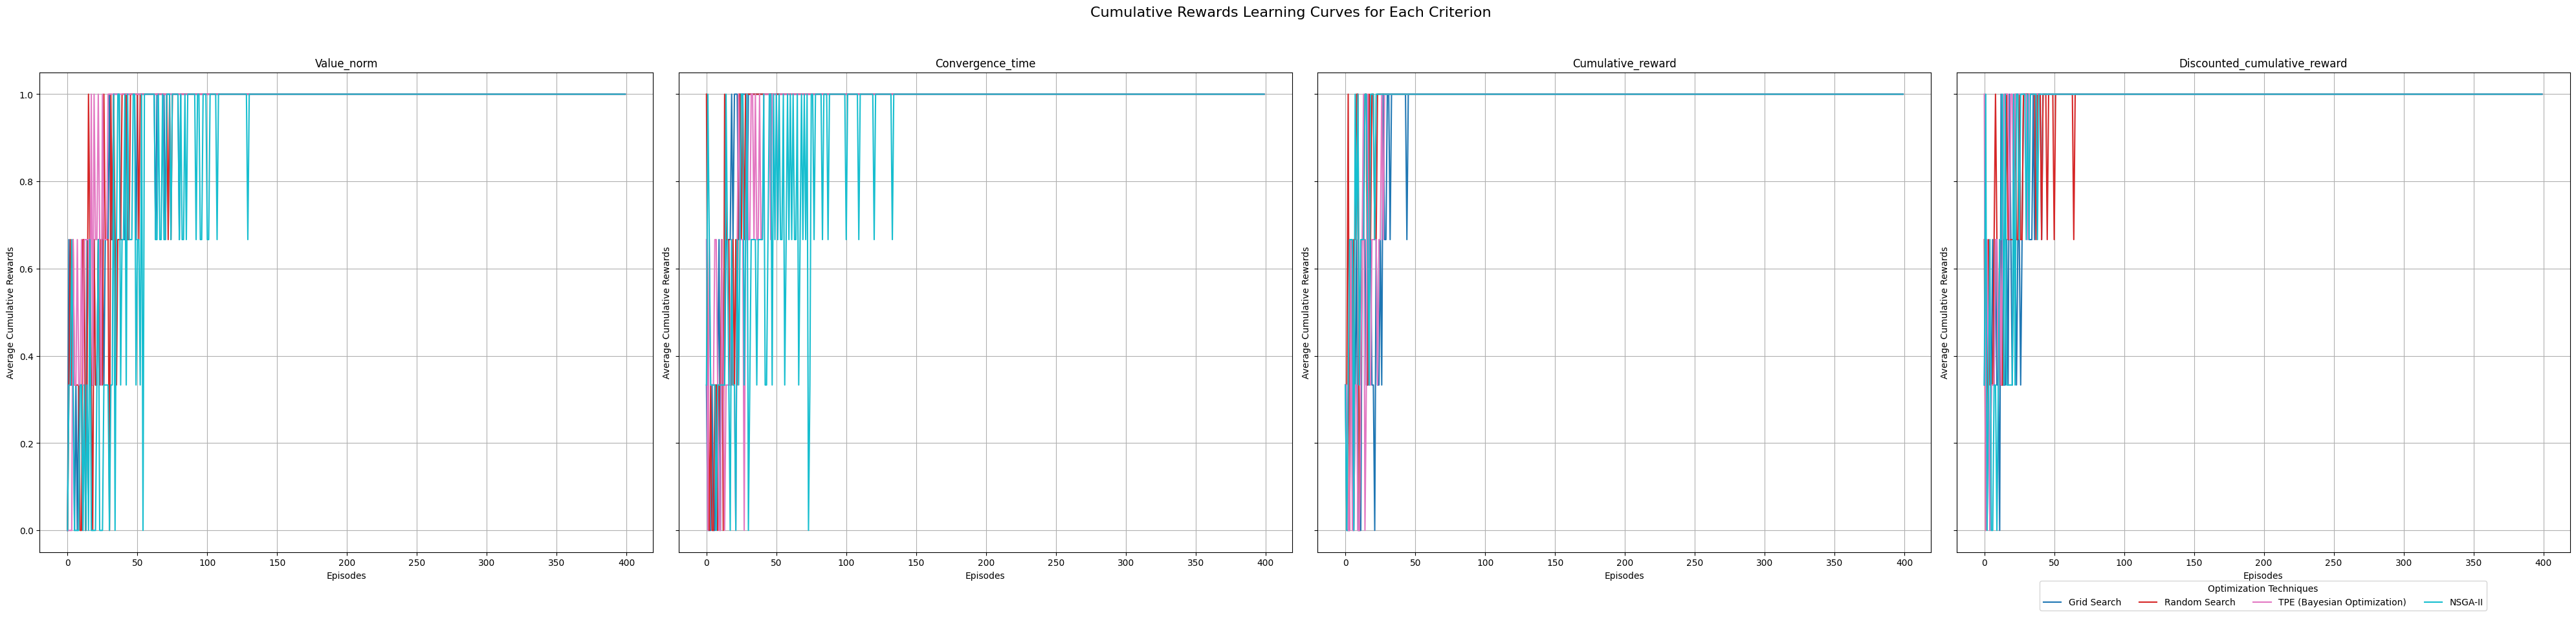

In [134]:
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Cumulative Rewards", compute_cumulative_rewards)


## The heat maps

### Value norms

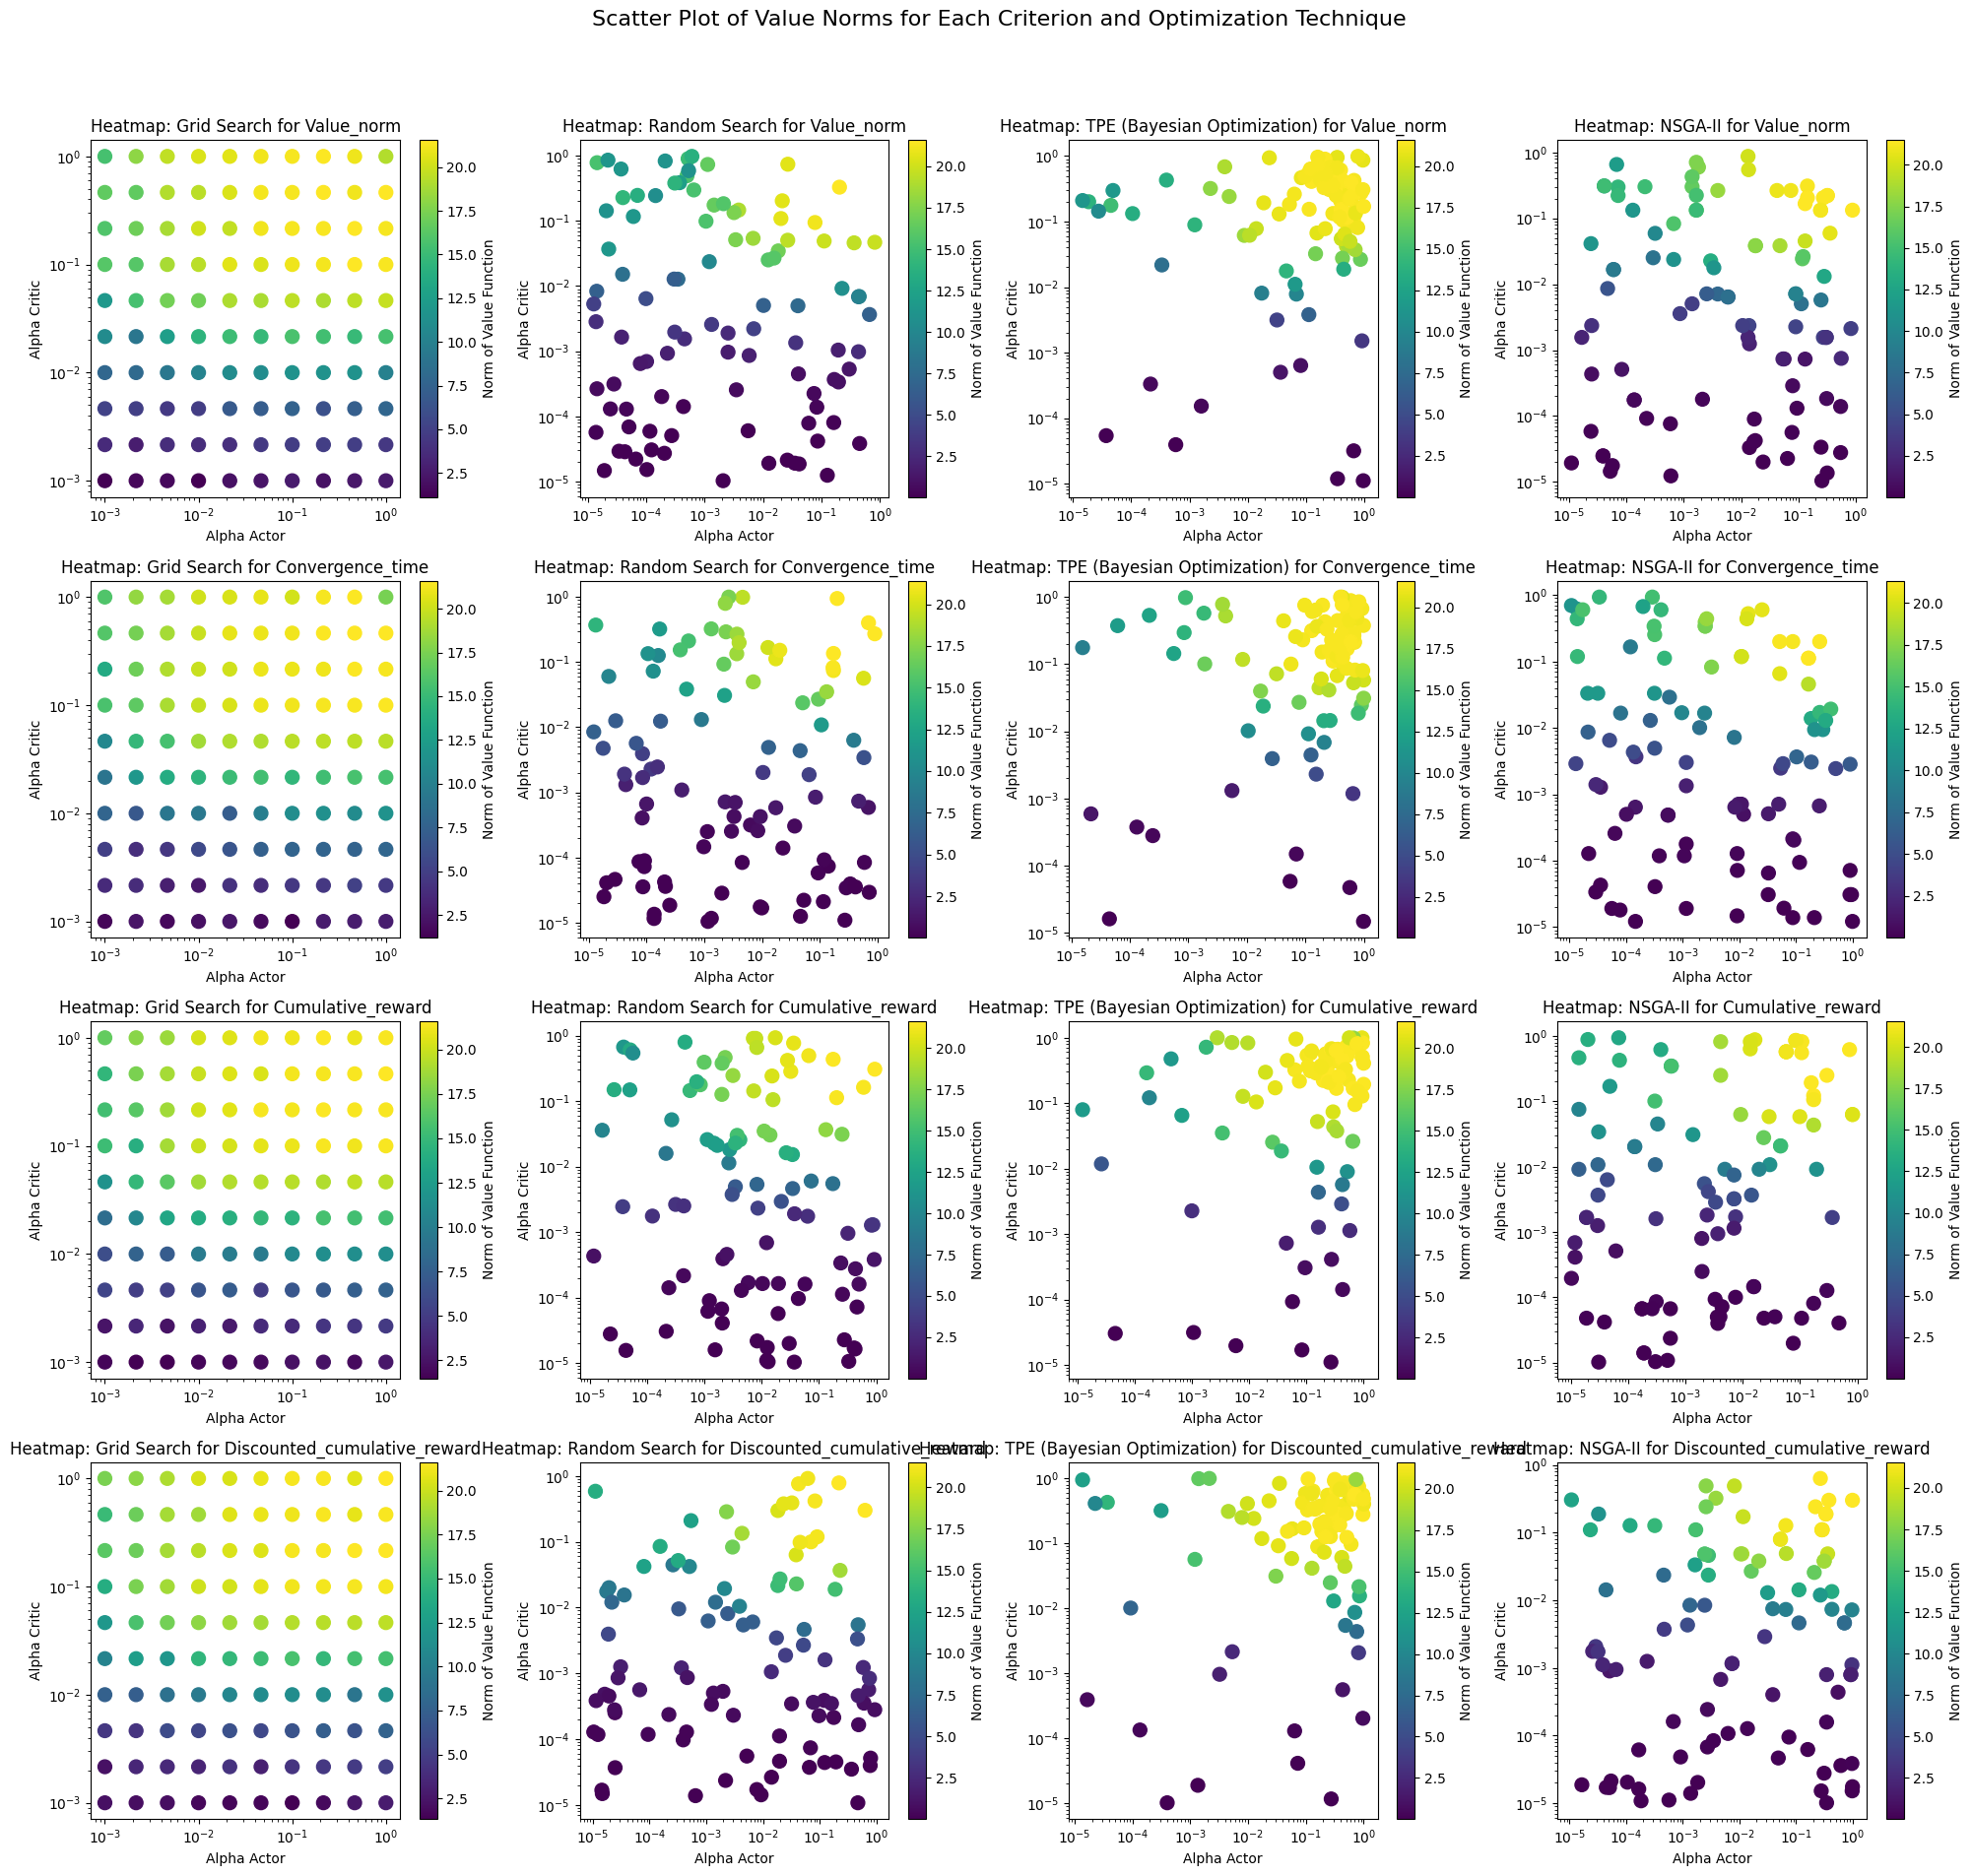

In [135]:
# Number of rows and columns for the grid of scatter plots
n_rows = len(criteria)  # Each row corresponds to a criterion
n_cols = len(SAMPLERS)  # Each column corresponds to an optimization technique

# Create a grid of subplots for the scatter plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
fig.suptitle("Scatter Plot of Value Norms for Each Criterion and Optimization Technique", fontsize=16)

# Iterate through each criterion (rows)
for i, criterion in enumerate(criteria):
    # Iterate through each sampler (columns)
    for j, sampler_name in enumerate(SAMPLERS.keys()):
        # Get the result key for the current criterion and sampler
        result_key = f"{criterion}_{sampler_name}"
        result = results.get(result_key)

        if result is None:
            continue  # Skip if there is no result for this combination

        # Extract the hyperparameter values and corresponding value norms
        alpha_actor_vals = [params[0] for params in result['all_params']]
        alpha_critic_vals = [params[1] for params in result['all_params']]
        value_norms = result['value_norms']

        # Select the correct subplot (axs is a grid)
        ax = axs[i, j]

        # Create the scatter plot
        scatter = ax.scatter(alpha_actor_vals, alpha_critic_vals, c=value_norms, cmap='viridis', s=100)

        # Set logarithmic scale for both axes
        ax.set_xscale('log')
        ax.set_yscale('log')

        # Add labels and titles
        ax.set_xlabel("Alpha Actor")
        ax.set_ylabel("Alpha Critic")
        ax.set_title(f"Heatmap: {sampler_name} for {criterion.capitalize()}")

        # Add a colorbar for each plot to represent the value norms
        fig.colorbar(scatter, ax=ax, label='Norm of Value Function')

# Adjust layout to ensure the plots are spaced properly
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()

### The Cumulative Rewards

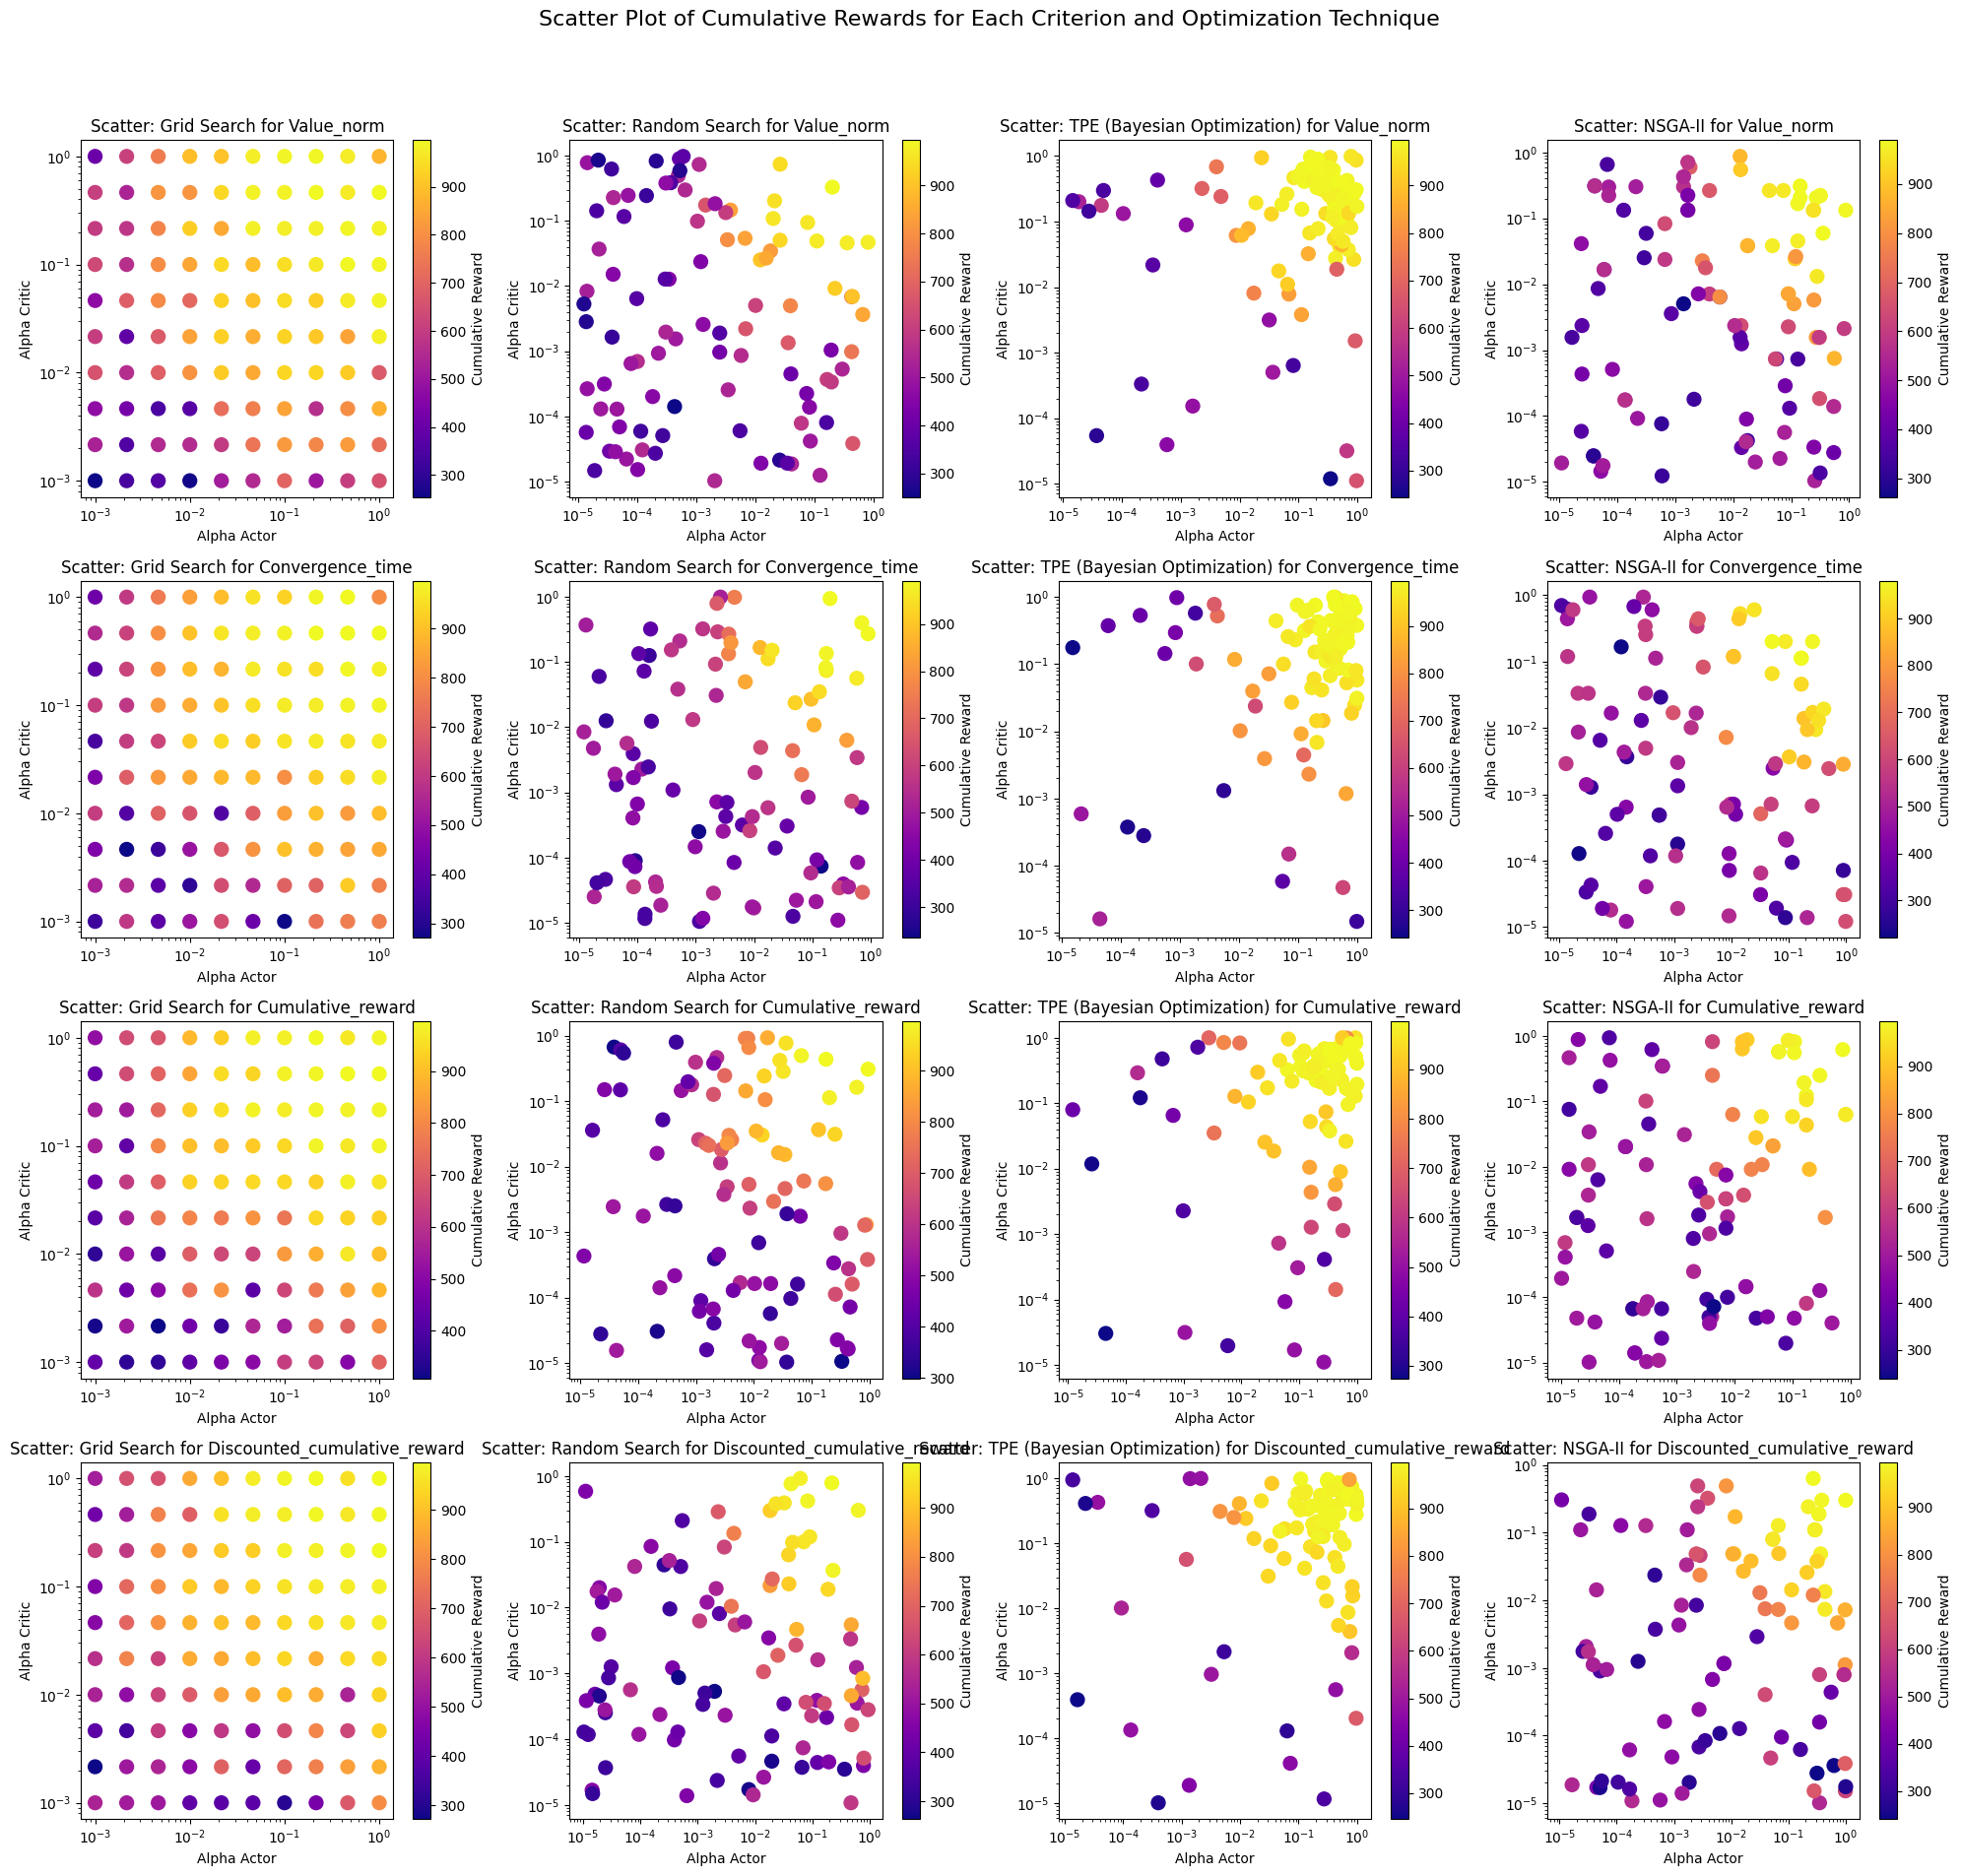

In [95]:
# Number of rows and columns for the grid of scatter plots
n_rows = len(criteria)  # Each row corresponds to a criterion
n_cols = len(SAMPLERS)  # Each column corresponds to an optimization technique

# Create a grid of subplots for the scatter plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
fig.suptitle("Scatter Plot of Cumulative Rewards for Each Criterion and Optimization Technique", fontsize=16)

# Iterate through each criterion (rows)
for i, criterion in enumerate(criteria):
    # Iterate through each sampler (columns)
    for j, sampler_name in enumerate(SAMPLERS.keys()):
        # Get the result key for the current criterion and sampler
        result_key = f"{criterion}_{sampler_name}"
        result = results.get(result_key)

        if result is None:
            continue  # Skip if there is no result for this combination

        # Extract the hyperparameter values and corresponding cumulative rewards
        alpha_actor_vals = [params[0] for params in result['all_params']]
        alpha_critic_vals = [params[1] for params in result['all_params']]
        cumulative_rewards = result['cumulative_rewards']

        # Select the correct subplot (axs is a grid)
        ax = axs[i, j]

        # Create the scatter plot for cumulative rewards
        scatter = ax.scatter(alpha_actor_vals, alpha_critic_vals, c=cumulative_rewards, cmap='plasma', s=100)

        # Set logarithmic scale for both axes
        ax.set_xscale('log')
        ax.set_yscale('log')

        # Add labels and titles
        ax.set_xlabel("Alpha Actor")
        ax.set_ylabel("Alpha Critic")
        ax.set_title(f"Scatter: {sampler_name} for {criterion.capitalize()}")

        # Add a colorbar for each plot to represent the cumulative rewards
        fig.colorbar(scatter, ax=ax, label='Cumulative Reward')

# Adjust layout to ensure the plots are spaced properly
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()


# Step 3: Statistical tests

# Tests

## Exercise 3

As hyper-parameters, you will use:

- naive tuning, that is a pair (0.5, 0.5) for the actor and critic learning rates,
- the best hyper-parameters you found with the different tuning algorithms you used before.

### 1. For each set of hyper-parameters, collect a large dataset of learning curves.

We suggest using 150 training episodes.

### 2. Perform statistical comparisons

- Take two datasets of learning curves obtained with the hyper-parameters sets that you found with different tuning algorithms.
- Use the ``` perform_test(...)``` function to compare each possible pair of sets.

You should obtain an image for each pair you have tried.
In this image, black dots signal the time step where there is a statistically significant difference between two learning curves.

 ### 3. Conclude.

# Lab report

Your report should contain:
- your source code (probably this notebook), do not forget to put your names on top of the notebook,
- in a separate pdf file with your names in the name of the file:
    + a detailed enough description of the choices you have made: the parameters you have set, the libraries you have used, etc.,
    + the heatmaps obtained using the hyper-parameters tuning algorithms that you have used,
    + the figures resulting from performing Welch's T-test using the best hyper-parameters from the above approaches,
    + your conclusion from these experiments.

Beyond the elements required in this report, any additional studies will be rewarded.
For instance, you can try using a Q-function as critic, using random search as hyper-parameters tuning algorithm,
using more challenging environments, etc.